In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import seaborn as sns
import random

In [2]:
# set the parameters
seeds = [3452, 3452, 3452]

# number of periods
T = 10

# number of trials
be_trials = 10

# alpha threshold for the switcher 
# (this will be estimated bu maximum likelihood from the data on the tables they are choosing to see)
a = 1

# base rate neglect (taken from Drobner and Goerg, 2022)
d = 1

# self-serving bias (overweight positive signals and underweight negative ones when updating on type and 
# do the opposite when updating on the exogenour parameter, also taken from Drobner and Goerg for now)
c_theta_positive = 1.9
c_theta_negative = .1
c_omega_positive = .1
c_omega_negative = 1.9

attributions = [c_theta_positive, c_theta_negative, c_omega_positive, c_omega_negative]

In [3]:
random.seed(3452
           )
        # draw the exogenous parameter for each task. It is 0, 1 or 2.
        # These are the same for all players and are saved at the session level
        # we want them to stay the same across sessions as well which is why a seed was set in advance
a = random.randint(0, 2)
b = random.randint(0, 2)
c = random.randint(0, 2)
d = random.randint(0, 2)
e = random.randint(0, 2)
f = random.randint(0, 2)

[a, b, c, d, e, f]

[1, 1, 0, 0, 1, 2]

In [4]:
# matrices: matrix[0] is the low type, matrix[2] is the high type. column 0 is low omega, row 0 is low effort
ml = np.array([[.20, .25, .40], [.07, .30, .45], [.02, .20, .50]])
mm = np.array([[.40, .45, .65], [.30, .65, .69], [.05, .50, .80]])
mh = np.array([[.45, .55, .75], [.35, .69, .80], [.25, .65, .98]])

msc = [ml, mm, mh]


$\pi_{t+1}[\theta_h|s]=\frac{P[s|\theta_H]^c\pi_{t}[\theta_H]^d}{P[s|\theta_H]^c\pi_{t}[\theta_H]^d+P[s|\theta_M]^c\pi_{t}[\theta_M]^d+P[s|\theta_L]^c\pi_{t}[\theta_L]^d}$

with $c = c_g^\theta$ if the signal is good and $c=c_b^\theta$ if the signal is bad

the signal is good if there are half or more successes and it is bad if there are fewer than half successes and $c_g^\theta > c_b^\theta$ 

To update $\omega$ it is analogous with the corresponding values of c.

In [5]:
# generalized bayes update: if the bias parameters are all 1, it is bayes, if d is less than one it is base rate-neglect
# if c is not all ones, it is attribution bias.
def bayes_biases(c, brn, p0_theta, p0_omega, signal, M, e_index):
    # c is the vector of attribution biases [theta_positive, theta_negative, omega_positive, omega_negative]
    # brn is the base rate neglect parameter
    # p0 are the priors
    # the signal is a binary vector of length be_trials 
    # M is the 3 matrices with the probabilitites of success conditional on each of the values of theta and omega
    # e_index is the effort level chosen in the round
    
    # nuber of sucesses
    k = sum(signal)
    n = len(signal)
    # set the exponents for the bias
    if k>=n/2:
        c_theta = c[0]
        c_omega = c[2]
    else:
        c_theta = c[1]
        c_omega = c[3]
    # matrix with all the probabilities (the row corresponding to e_index) stacked by theta
    matrix = np.array([sp.stats.binom.pmf(k, n, M[0][e_index, :], loc=0), 
                       sp.stats.binom.pmf(k, n, M[1][e_index, :], loc=0), 
                       sp.stats.binom.pmf(k, n, M[2][e_index, :], loc=0)])
    
    # The first term in the numerator 
    p_omega = np.power(p0_theta@matrix, c_omega)
    p_theta = np.power(matrix@p0_omega, c_theta)
     
    # multiply by the prior to the brn to get the 3 numerators
    num_omega = np.diag( np.diagflat(p_omega) @ np.power(np.diagflat(p0_omega), brn) )
    num_theta = np.diag( np.diagflat(p_theta) @ np.power(np.diagflat(p0_theta), brn) )
    
    # denominator is the sum of the numerators
    denom_o = np.sum(num_omega)
    denom_th = np.sum(num_theta)
    
    # the posterior beiefs
    p1_omega = num_omega/denom_o
    p1_theta = num_theta/denom_th
    
    # save the likelihoods for theta in a vector with [H/M, M/L, H/L]
    likelihoods = [num_theta[2]/num_theta[1], num_theta[1]/num_theta[0], num_theta[2]/num_theta[0]]

        
    return p1_theta, p1_omega, likelihoods
    
    

In [6]:
def update_dog(prior, type_belief, signal, M, e_index):
    k = sum(signal)
    n = len(signal)
    
    p = sp.stats.binom.pmf(k, n, M[type_belief][e_index, :], loc=0)
    
    num = np.diag(np.diagflat(prior)@np.diagflat(p))
    denom = sum(num)
    
    posterior = num/denom
    
    return posterior
    
    

In [7]:
def update_lr(prior, type_belief, signal, M, e_index):
    k = sum(signal)
    n = len(signal)
    
    p = sp.stats.binom.pmf(k, n, M[type_belief][e_index, :], loc=0)
    
    num = np.diag(np.diagflat(prior)@np.diagflat(p))
    denom = sum(num)
    
    posterior = num/denom
    
    likelihoods = [num[0], num[1], num[2]]
    
    return posterior, likelihoods

In [8]:
# a function that chooses a level of effort for the dogmatic and the switcher
def choice_dog(prior, type_belief, M):
    # type belief should be 0, 1, or 2
    # the prior is over omegas. 
    # M is a vector of the three probability matrices (L, M, H)
    # calculate the expected utility from each choice
    Eu = np.dot(M[type_belief], prior)
    # element that maximizes the flow utility is the choice
    e_index = np.argmax(Eu)
    
    return e_index

In [9]:
# a function that chooses the level of effort for the bayesian and the self-serving
def choice_bay(p0_theta, p0_omega, M):
    # expected utility consitional on each type and each choice
    Eu_theta = [np.dot(M[0], p0_omega), np.dot(M[1], p0_omega), np.dot(M[2], p0_omega)]
    # Expected utility conditional only on choices
    Eu = np.dot(np.transpose(Eu_theta), p0_theta)
    e_index = np.argmax(Eu) 
    
    return e_index



In [10]:
def simulate(theta, omega, p0_theta, p0_omega, M, c, d, T, N, trials, seeds, alpha):
    
    ###### Determine the outcomes beforehand
    # set a seed for each type
    rng_H = np.random.default_rng(seed=seeds[0])
    
    

    #############
    # generate all the draws for T periods for each type and for each effort choice
    ############

    ##### for the high types
    # outcomes after choosing L
    outcome_H_L = rng_H.binomial(1, M[2][0, omega], size=(T, be_trials))
    # outcomes after choosing M
    outcome_H_M = rng_H.binomial(1, M[2][1, omega], size=(T, be_trials))
    # outcomes after choosing H
    outcome_H_H = rng_H.binomial(1, M[2][2, omega], size=(T, be_trials))

    ##### for the medium types
    rng_M = np.random.default_rng(seed=seeds[1])
    # after low effort
    outcome_M_L = rng_M.binomial(1, M[1][0, omega], size=(T, be_trials))
    # after medium effort
    outcome_M_M = rng_M.binomial(1, M[1][1, omega], size=(T, be_trials))
    # after high effort
    outcome_M_H = rng_M.binomial(1, M[1][2, omega], size=(T, be_trials))

    #### for the low types
    rng_L = np.random.default_rng(seed=seeds[2])
    outcomes_L_L = rng_L.binomial(1, M[0][0, omega], size=(T, be_trials))
    outcomes_L_M = rng_L.binomial(1, M[0][1, omega], size=(T, be_trials))
    outcomes_L_H = rng_L.binomial(1, M[0][2, omega], size=(T, be_trials))

    # stack the outcome vectors foe each type into a matrix. first element is the effort choice, secod is t
    outcomes_H = np.stack((outcome_H_L, outcome_H_M, outcome_H_H))
    outcomes_M = np.stack((outcome_M_L, outcome_M_M, outcome_M_H))
    outcomes_L = np.stack((outcomes_L_L, outcomes_L_M, outcomes_L_H))

    # stack all the matrices into a single outcomes matrix of matrices
    outcomes = np.stack((outcomes_L, outcomes_M, outcomes_H))
    
    
    #############
    # set empty vectors where all the data will be saved period by period for each of the models
    ############
    # beliefs
    p_theta_bay =[p0_theta]
    p_omega_bay = [p0_omega]
    
    p_theta_ss =[p0_theta]
    p_omega_ss = [p0_omega]
    
    p_theta_dog_L =[0]
    p_theta_dog_M =[1]
    p_theta_dog_H =[2]
    p_omega_dog_H = [p0_omega]
    p_omega_dog_M = [p0_omega]
    p_omega_dog_L = [p0_omega]
    
    theta_lr_L =[0]
    theta_lr_M =[1]
    theta_lr_H =[2]
    p_omega_lr_H = [p0_omega]
    p_omega_lr_M = [p0_omega]
    p_omega_lr_L = [p0_omega]
    
    # choices
    e_bay = [choice_bay(p0_theta, p0_omega, M)]
    
    e_ss = [choice_bay(p0_theta, p0_omega, M)]
    
    e_dog_L = [0]
    e_dog_M = [1]
    e_dog_H = [2]
    
    e_lr_L = [0]
    e_lr_M = [1]
    e_lr_H = [2]
    
    # likelihood theta H/M, M/L, H/L
    likelihoods = [[p0_theta[2]/p0_theta[1], p0_theta[1]/p0_theta[0], p0_theta[2]/p0_theta[0]]]
    
    signals = outcomes[theta]
    
    for t in range(T):
        # get the signals for each model
        signal_dog_H = signals[e_dog_H[t], omega]
        signal_dog_M = signals[e_dog_M[t], omega]
        signal_dog_L = signals[e_dog_L[t], omega]
        
        signal_lr_H = signals[e_lr_H[t], omega]
        signal_lr_M = signals[e_lr_M[t], omega]
        signal_lr_L = signals[e_lr_L[t], omega]
        
        signal_bay = signals[e_bay[t], omega]
        signal_ss = signals[e_ss[t], omega]
        
        # update beliefs for each model and each believed type
        
        ### bayesian
        bay_theta, bay_omega, bay_lr = bayes_biases([1,1,1, 1], 1, p_theta_bay[t], p_omega_bay[t], signal_bay, M, e_bay[t])
        p_theta_bay.append(bay_theta)
        p_omega_bay.append(bay_omega)
        
        ### self-serving
        ss_theta, ss_omega, ss_lr = bayes_biases(c, d, p_theta_ss[t], p_omega_ss[t], signal_ss, M, e_ss[t])
        p_theta_ss.append(ss_theta)
        p_omega_ss.append(ss_omega)
        
        ### likelihood ratio
        omega_lr_H, l_H = update_lr(p_omega_lr_H[t], theta_lr_H[t], signal_lr_H, M, e_lr_H[t])
        omega_lr_M, l_M = update_lr(p_omega_lr_M[t], theta_lr_M[t], signal_lr_M, M, e_lr_M[t])
        omega_lr_L, l_L = update_lr(p_omega_lr_L[t], theta_lr_L[t], signal_lr_L, M, e_lr_L[t])
        
        p_omega_lr_H.append(omega_lr_H)
        p_omega_lr_M.append(omega_lr_M)
        p_omega_lr_L.append(omega_lr_L)
        
        ### dogmatic
        omega_dog_H = update_dog(p_omega_dog_H[t], 2, signal_dog_H, M, e_dog_H[t])
        omega_dog_M = update_dog(p_omega_dog_M[t], 1, signal_dog_M, M, e_dog_M[t])
        omega_dog_L = update_dog(p_omega_dog_L[t], 0, signal_dog_L, M, e_dog_L[t])
        
        p_omega_dog_H.append(omega_dog_H)
        p_omega_dog_M.append(omega_dog_M)
        p_omega_dog_L.append(omega_dog_L)
        
        
        # take the most likely type and check if the likelihood ratio vs the current model is above alpha
        # if it is, set it as the theta for the switcher
        
        H_top = np.argmax(l_H)
        H_current = theta_lr_H[t]
        LR_H = l_H[H_top]/l_H[H_current]
        
        if LR_H >= alpha:
            theta_lr_H.append(theta)
        else:
            theta_lr_H.append(H_current) 
        
        M_top = np.argmax(l_M)
        M_current = theta_lr_M[t]
        LR_M = l_M[theta]/l_M[M_current]
        
        if LR_M >= alpha:
            theta_lr_M.append(theta)
        else:
            theta_lr_M.append(M_current)
            
        L_top = np.argmax(l_L)
        L_current = theta_lr_L[t]
        LR_L = l_L[theta]/l_L[L_current]
        
        if LR_L >= alpha:
            theta_lr_L.append(theta)
        else:
            theta_lr_L.append(L_current)
        
        # Choices for each model and each believed type
        e_bay_t = choice_bay(bay_theta, bay_omega, M)
        e_bay.append(e_bay_t)
        
        e_ss_t = choice_bay(ss_theta, ss_omega, M)
        e_ss.append(e_ss_t)
        
        e_dog_H.append(choice_dog(omega_dog_H, 2, M))
        e_dog_M.append(choice_dog(omega_dog_M, 1, M))
        e_dog_L.append(choice_dog(omega_dog_L, 0, M))
        
        e_lr_H.append(choice_dog(omega_lr_H, theta_lr_H[-1], M))
        e_lr_M.append(choice_dog(omega_lr_M, theta_lr_M[-1], M))
        e_lr_L.append(choice_dog(omega_lr_L, theta_lr_L[-1], M))
        
    return [e_lr_L, e_lr_M, e_lr_H, 
            e_dog_L, e_dog_M, e_dog_H, 
            e_bay, e_ss, 
            theta_lr_L, theta_lr_M, theta_lr_H]


In [11]:
choices_00 = simulate(0, 0, [1/3,1/3, 1/3], [1/3,1/3, 1/3], msc, attributions, 1, T, 1, be_trials, seeds, a)
choices_01 = simulate(0, 1, [1/3,1/3, 1/3], [1/3,1/3, 1/3], msc, attributions, 1, T, 1, be_trials, seeds, a)
choices_02 = simulate(0, 2, [1/3,1/3, 1/3], [1/3,1/3, 1/3], msc, attributions, 1, T, 1, be_trials, seeds, a)

choices_10 = simulate(1, 0, [1/3,1/3, 1/3], [1/3,1/3, 1/3], msc, attributions, 1, T, 1, be_trials, seeds, a)
choices_11 = simulate(1, 1, [1/3,1/3, 1/3], [1/3,1/3, 1/3], msc, attributions, 1, T, 1, be_trials, seeds, a)
choices_12 = simulate(1, 2, [1/3,1/3, 1/3], [1/3,1/3, 1/3], msc, attributions, 1, T, 1, be_trials, seeds, a)

choices_20 = simulate(2, 0, [1/3,1/3, 1/3], [1/3,1/3, 1/3], msc, attributions, 1, T, 1, be_trials, seeds, a)
choices_21 = simulate(2, 1, [1/3,1/3, 1/3], [1/3,1/3, 1/3], msc, attributions, 1, T, 1, be_trials, seeds, a)
choices_22 = simulate(2, 2, [1/3,1/3, 1/3], [1/3,1/3, 1/3], msc, attributions, 1, T, 1, be_trials, seeds, a)

In [12]:
choices_22[10]

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

In [22]:
def plot(choices, theta, omega):
    
    fig, axs = plt.subplots(3, 3, figsize=(20, 15))
    axs[0,0].plot(choices[0])
    axs[0,1].plot(choices[1])
    axs[0,2].plot(choices[2])
    # plot the belief of type for the switcher
    #axs[0,0].plot(choices[8])
    #axs[0,1].plot(choices[9])
    #axs[0,2].plot(choices[10])
    
    axs[0, 0].set_title('switcher, belief L')
    axs[0, 1].set_title('switcher, belief M')
    axs[0, 2].set_title('switcher, belief H')

    axs[1,0].plot(choices[3])
    axs[1,1].plot(choices[4])
    axs[1,2].plot(choices[5])
    
    axs[1, 0].set_title('dogmatic, belief L')
    axs[1, 1].set_title('dogmatic, belief M')
    axs[1, 2].set_title('dogmatic, belief H')

    axs[2,0].plot(choices[6])
    axs[2,1].plot(choices[7])
    
    axs[2, 0].set_title('Bayesian')
    axs[2, 1].set_title('Self Serving')
    
    axs[0, 0].set_ylim(-0.5, 2.5)
    axs[0, 1].set_ylim(-.5, 2.5)
    axs[0, 2].set_ylim(-.5, 2.5)
    axs[1, 0].set_ylim(-.5, 2.5)
    axs[1, 1].set_ylim(-.5, 2.5)
    axs[1, 2].set_ylim(-.5, 2.5)
    axs[2, 0].set_ylim(-.5, 2.5)
    axs[2, 1].set_ylim(-.5, 2.5)
    axs[2, 2].set_ylim(-.5, 2.5)

    if theta == 1:
        type = 'Mid Type'
    if theta ==0:
        type = 'Low Type'
    if theta ==2:
        type = 'High Type'

    axs[2,0].set_xlabel('round')
    axs[2,1].set_xlabel('round')
    axs[2,2].set_xlabel('round')

    axs[0, 0].set_ylabel('effort choice')
    axs[1, 0].set_ylabel('effort choice')
    axs[2, 0].set_ylabel('effort choice')

    axs[0, 0].set_yticks([0, 1, 2])
    axs[1, 0].set_yticks([0, 1, 2])
    axs[2, 0].set_yticks([0, 1, 2])

    axs[0, 1].set_yticks([0, 1, 2])
    axs[1, 1].set_yticks([0, 1, 2])
    axs[2, 1].set_yticks([0, 1, 2])

    axs[0, 2].set_yticks([0, 1, 2])
    axs[1, 2].set_yticks([0, 1, 2])
    axs[2, 2].set_yticks([0, 1, 2])
    
    fig.suptitle(type + ', rate = '+str(omega))

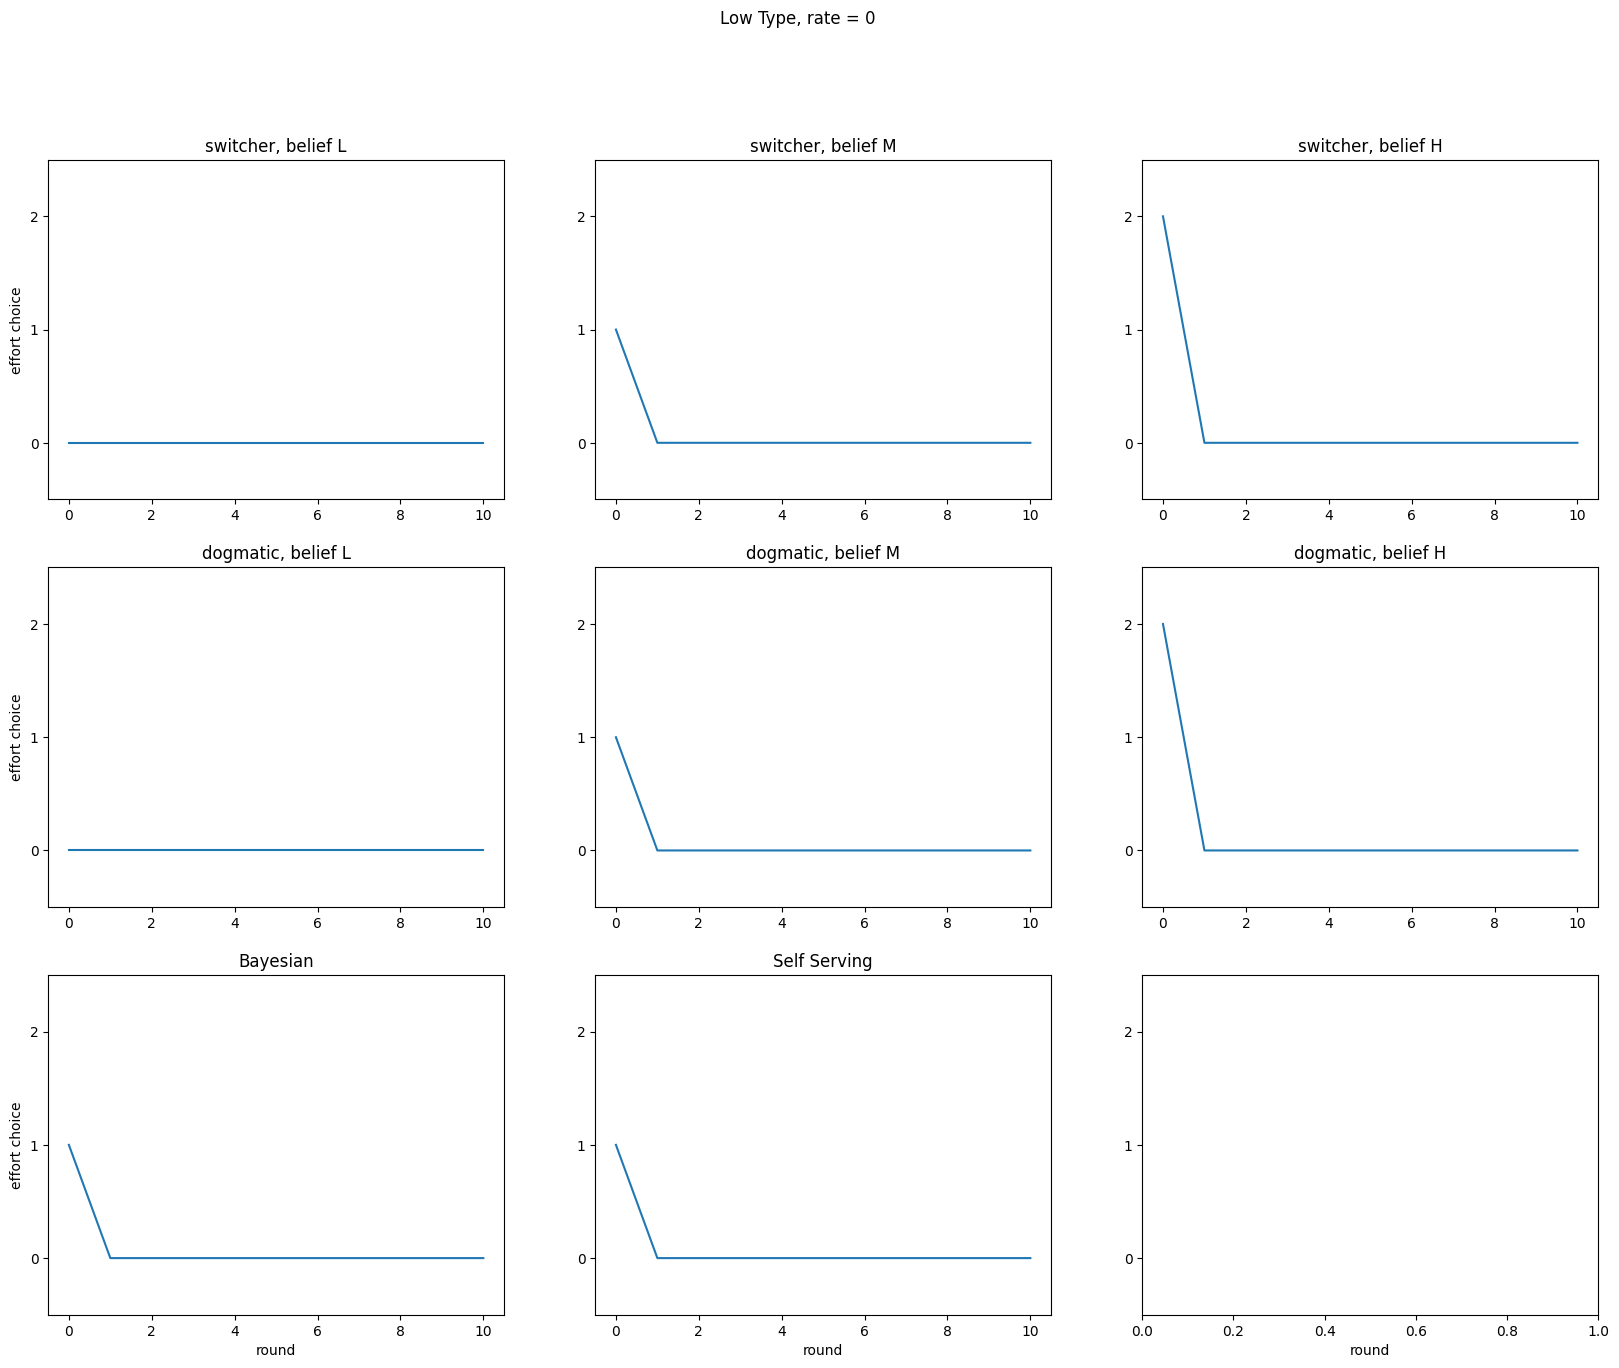

In [23]:
plot(choices_00, 0, 0)



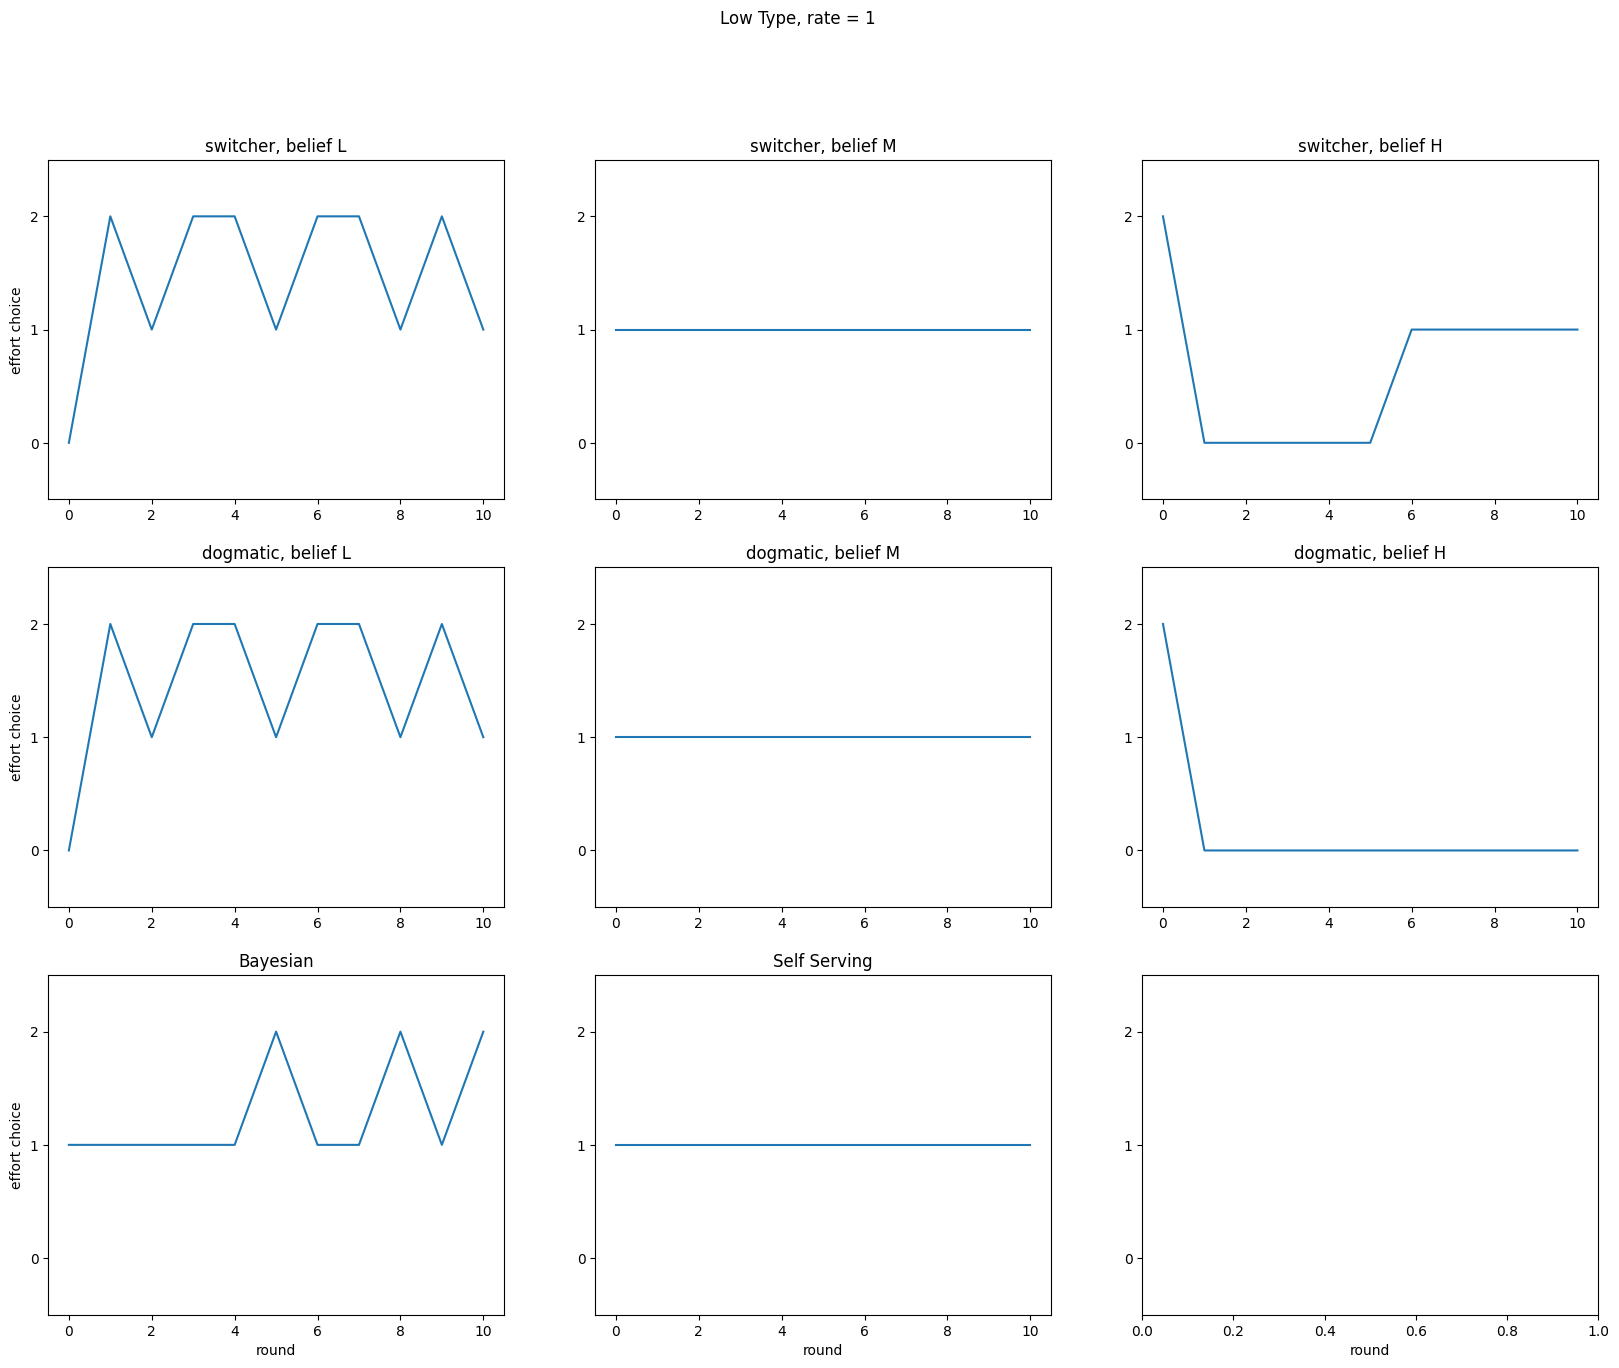

In [24]:
plot(choices_01, 0, 1)


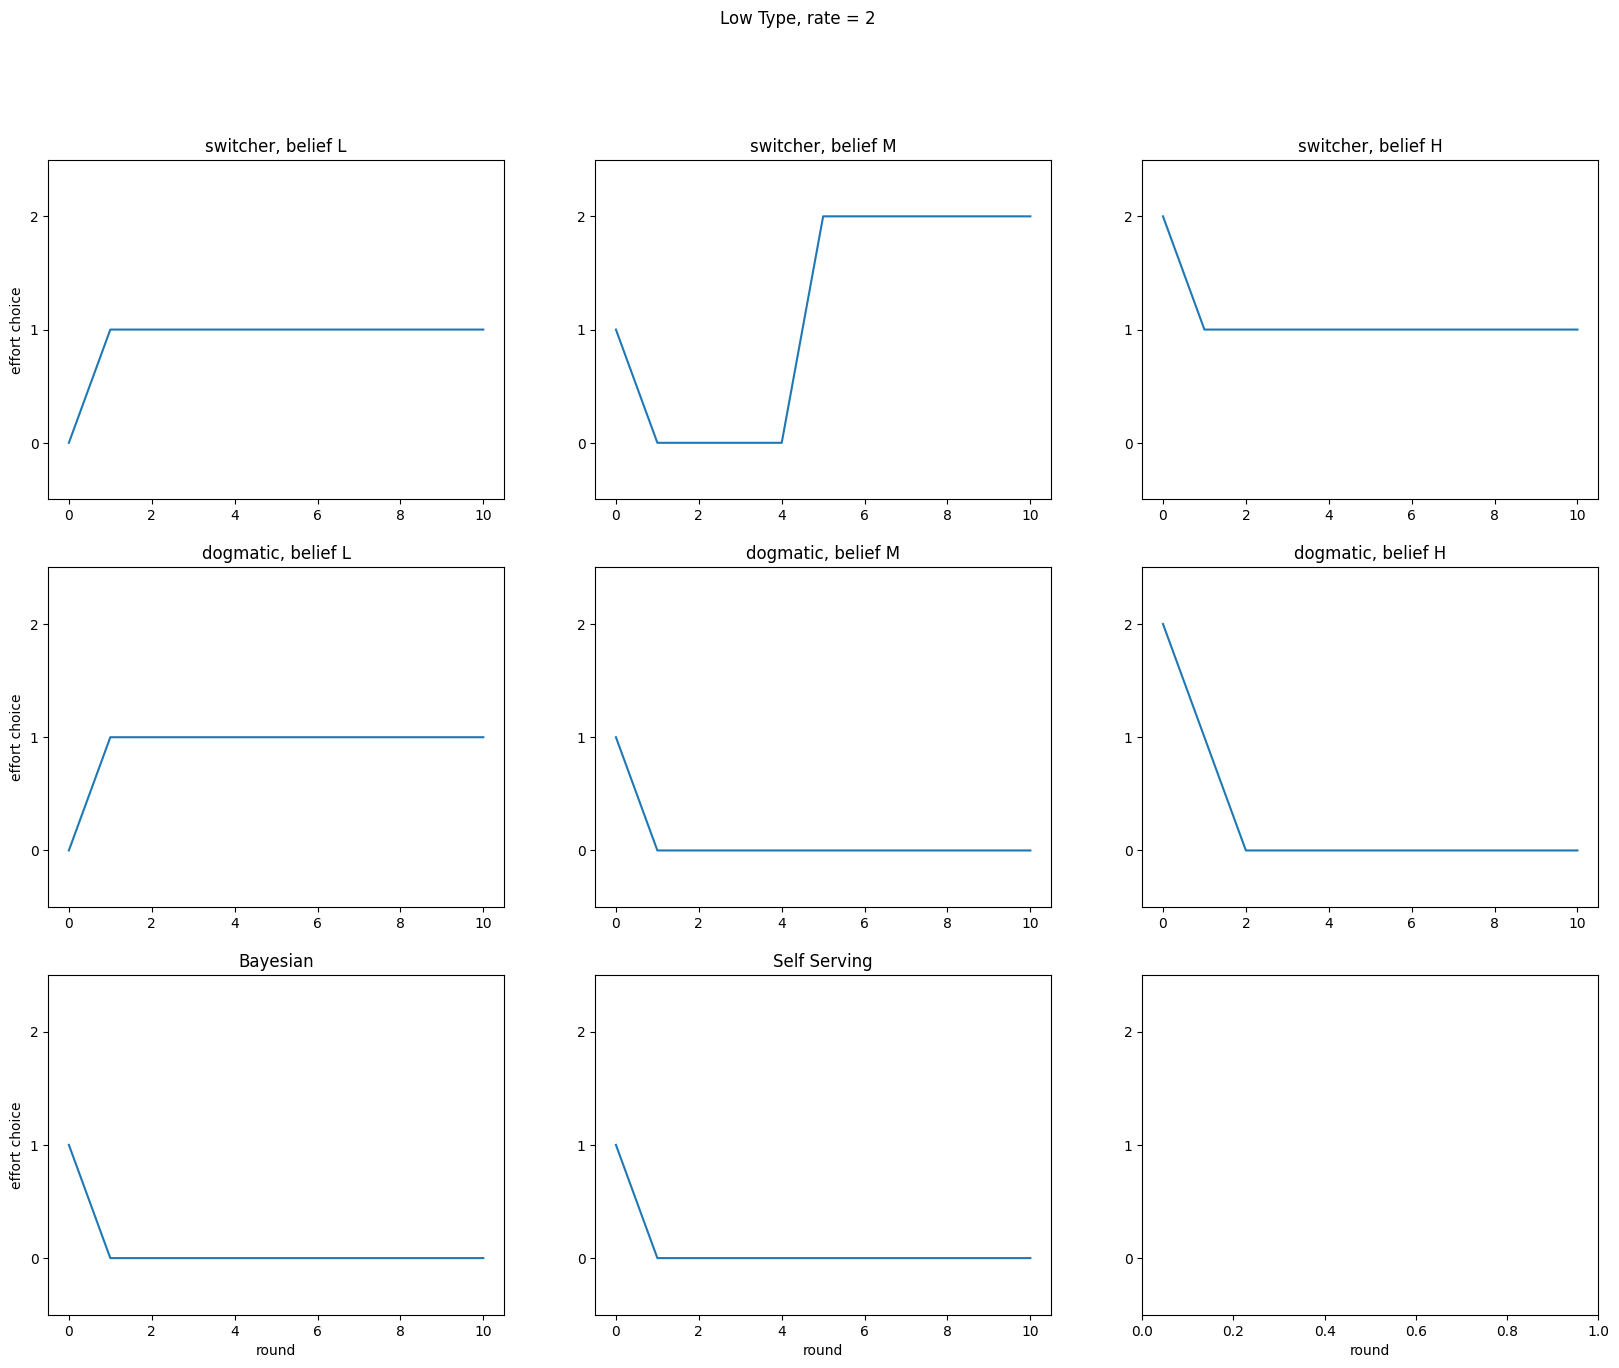

In [25]:
plot(choices_02, 0, 2)


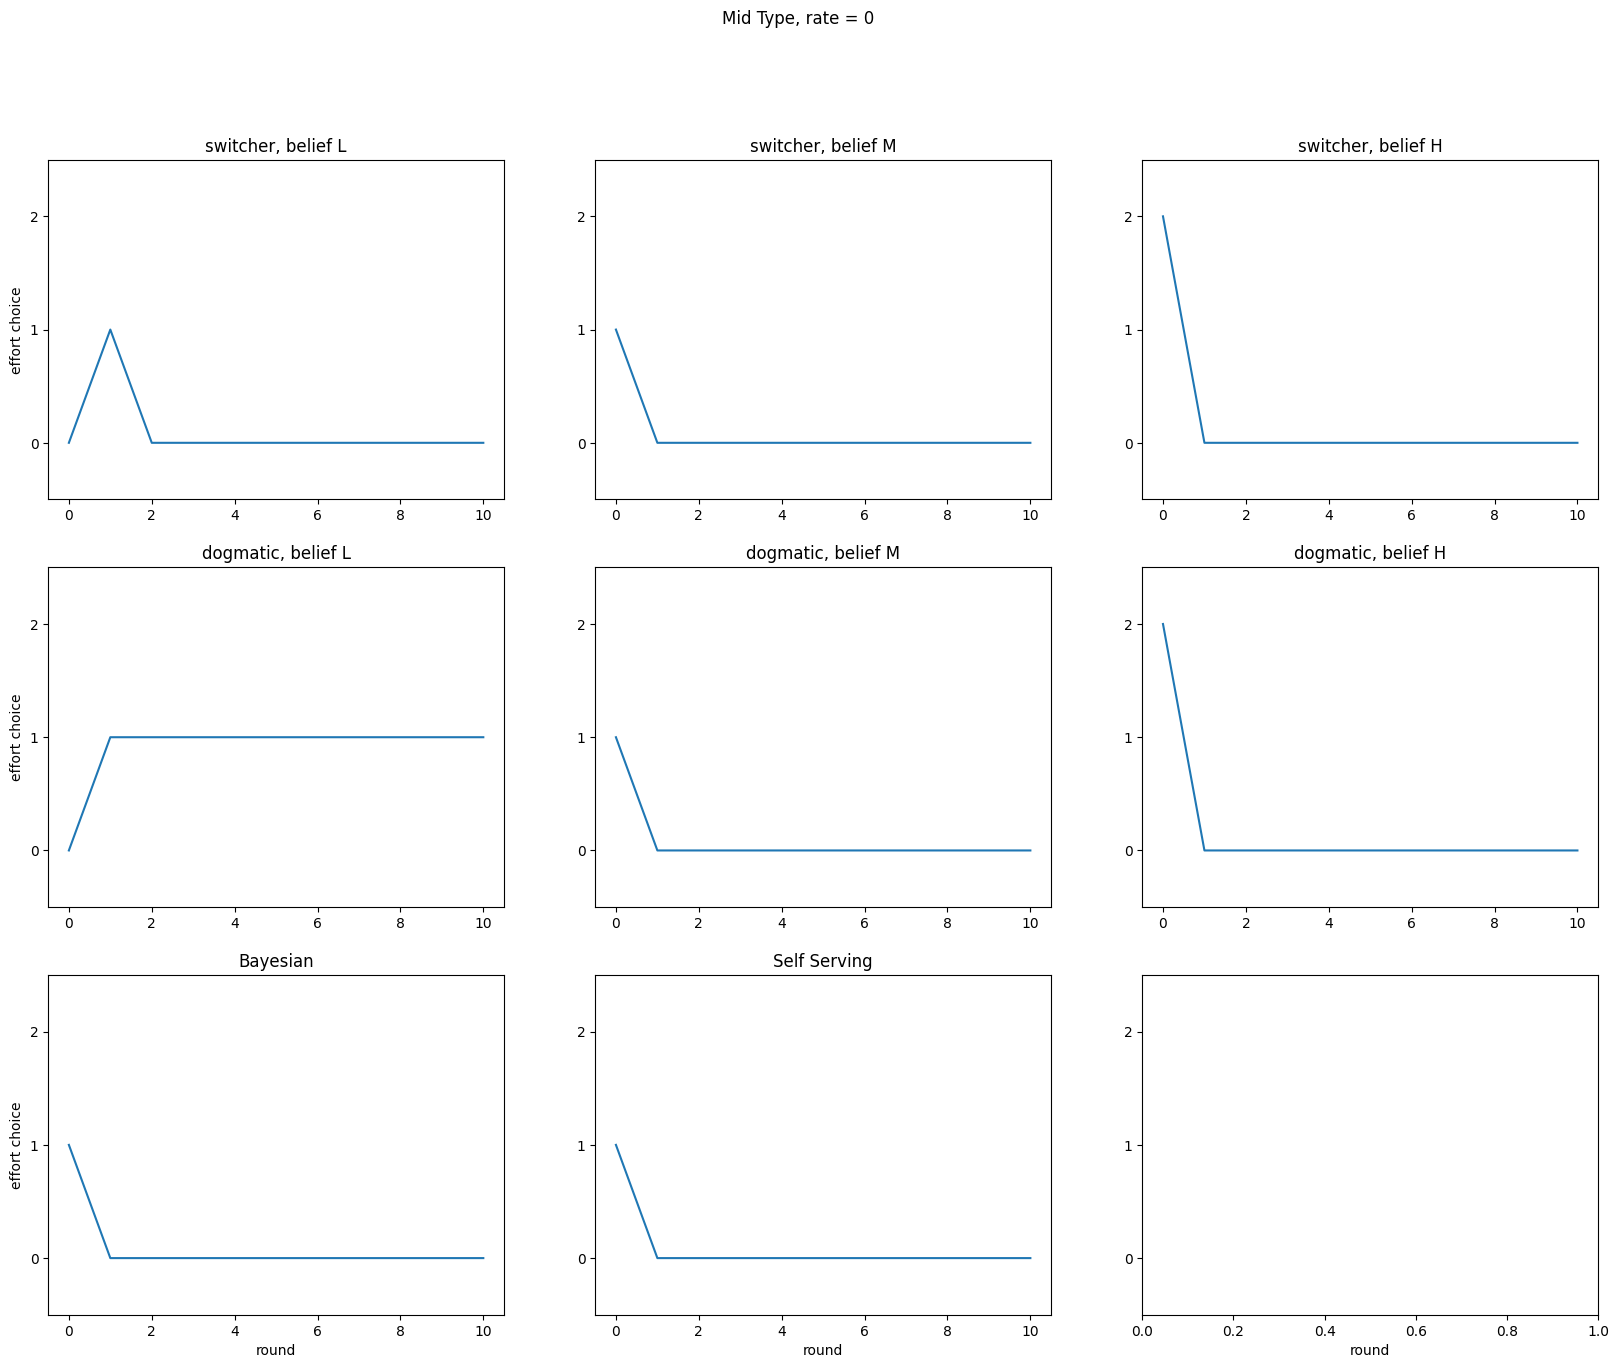

In [26]:
plot(choices_10, 1, 0)


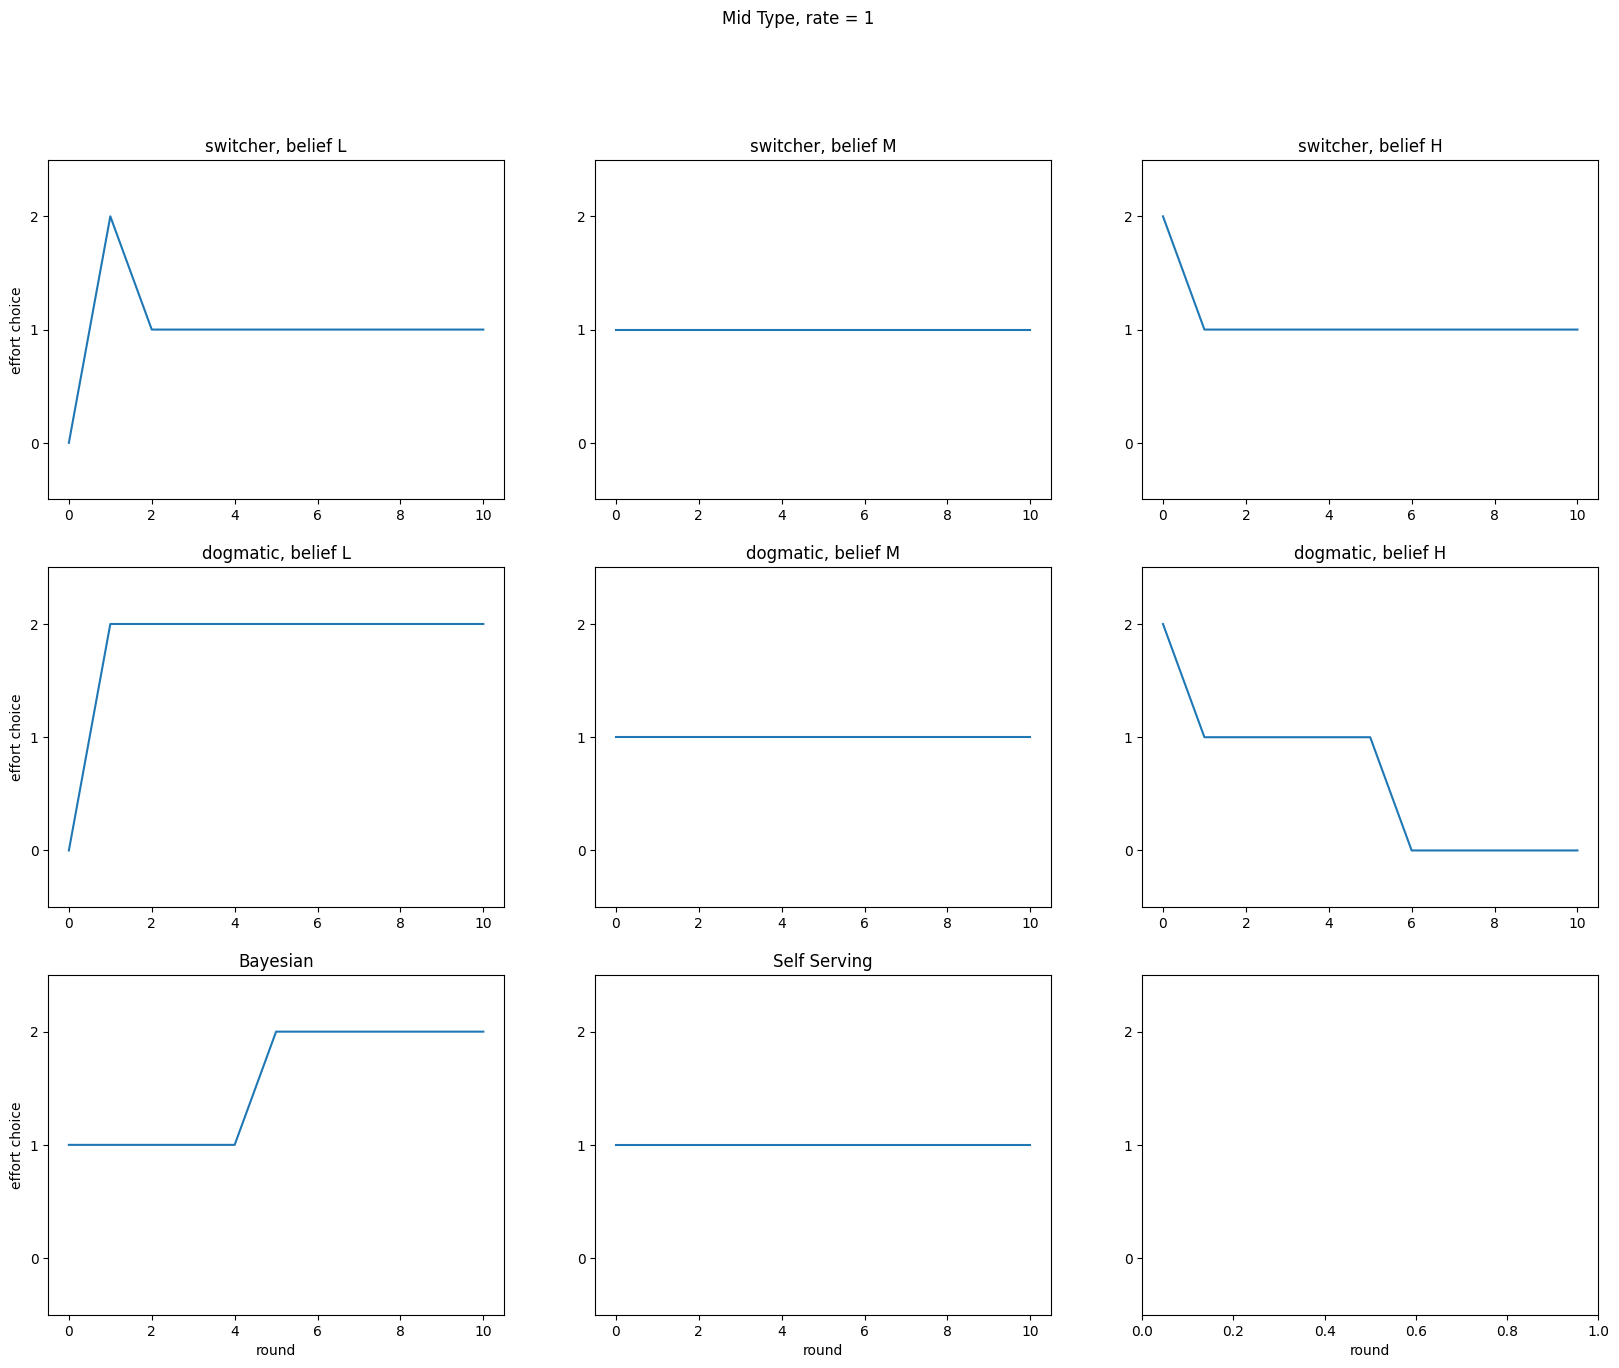

In [27]:
plot(choices_11, 1, 1)



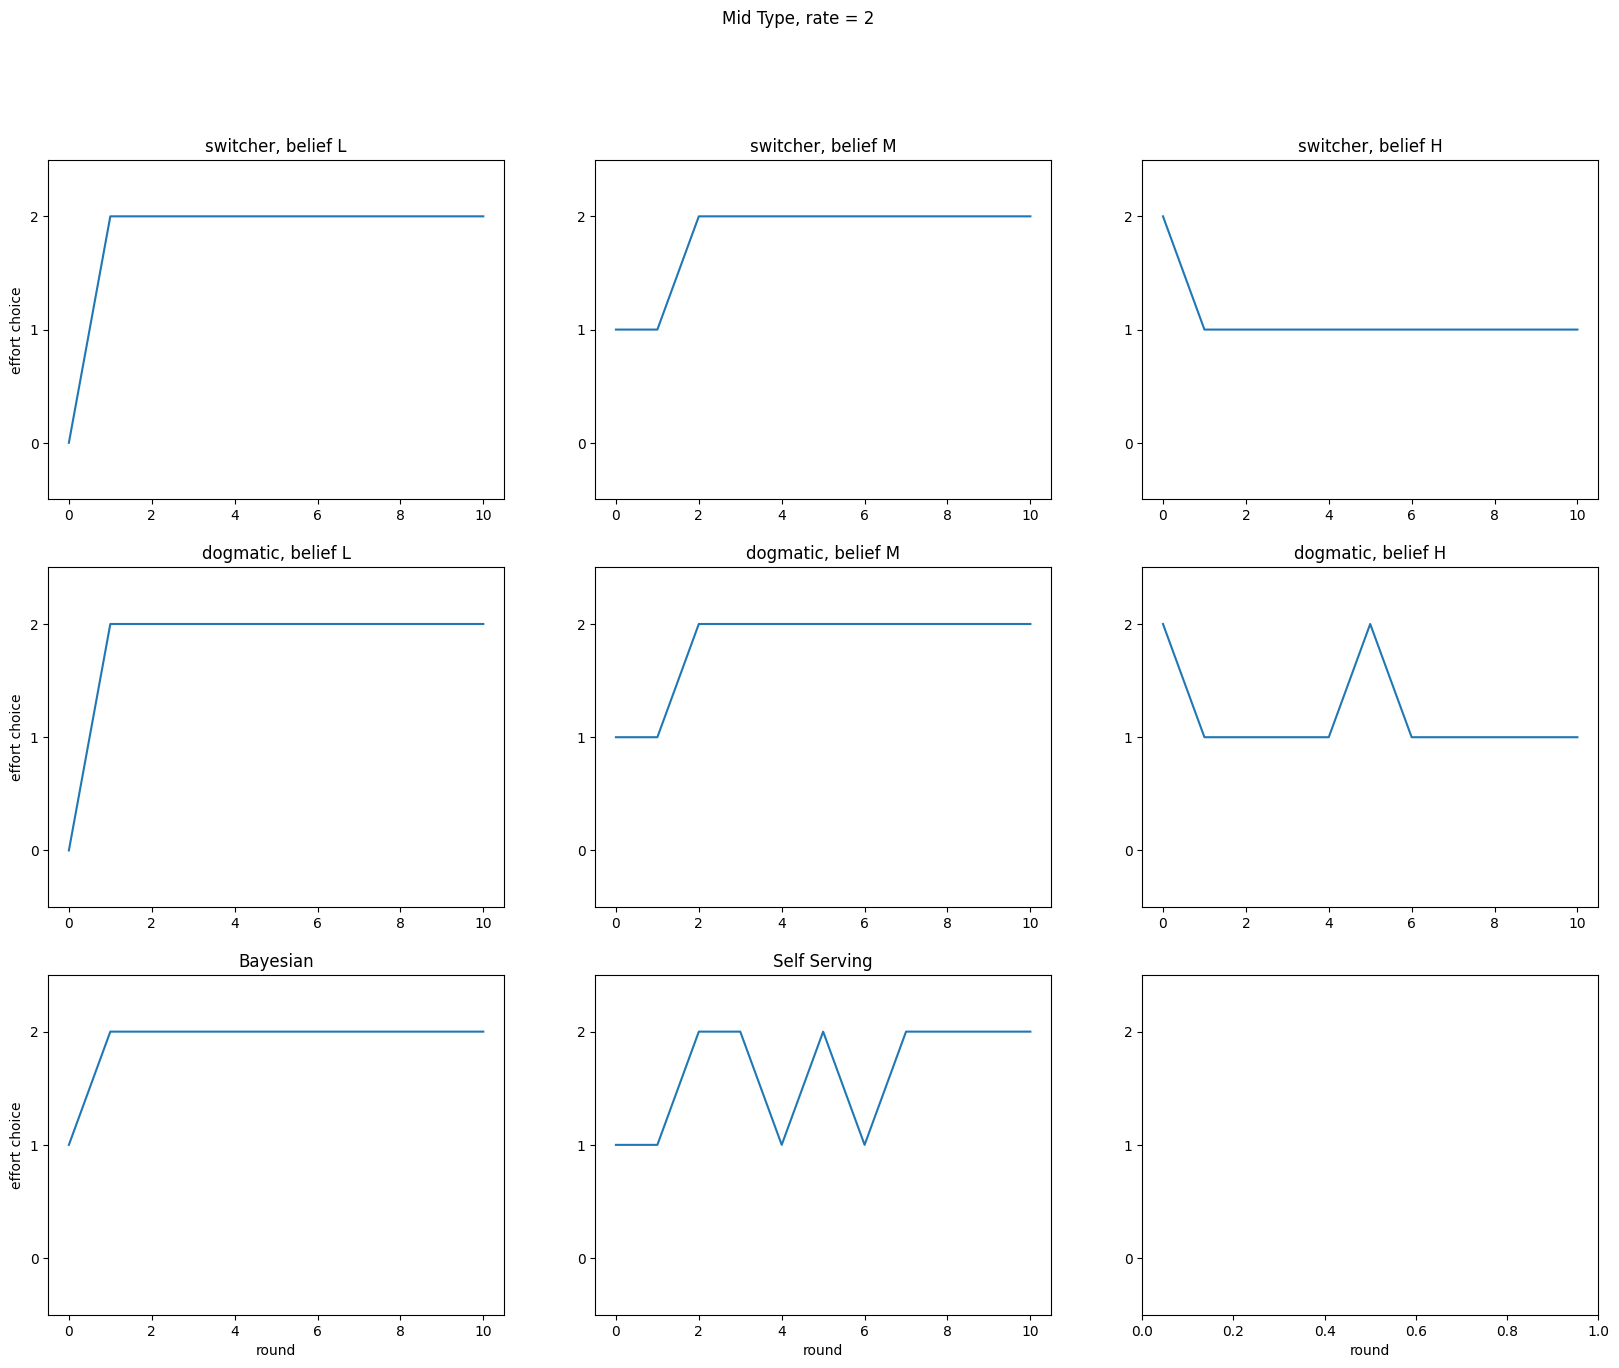

In [28]:
plot(choices_12, 1, 2)



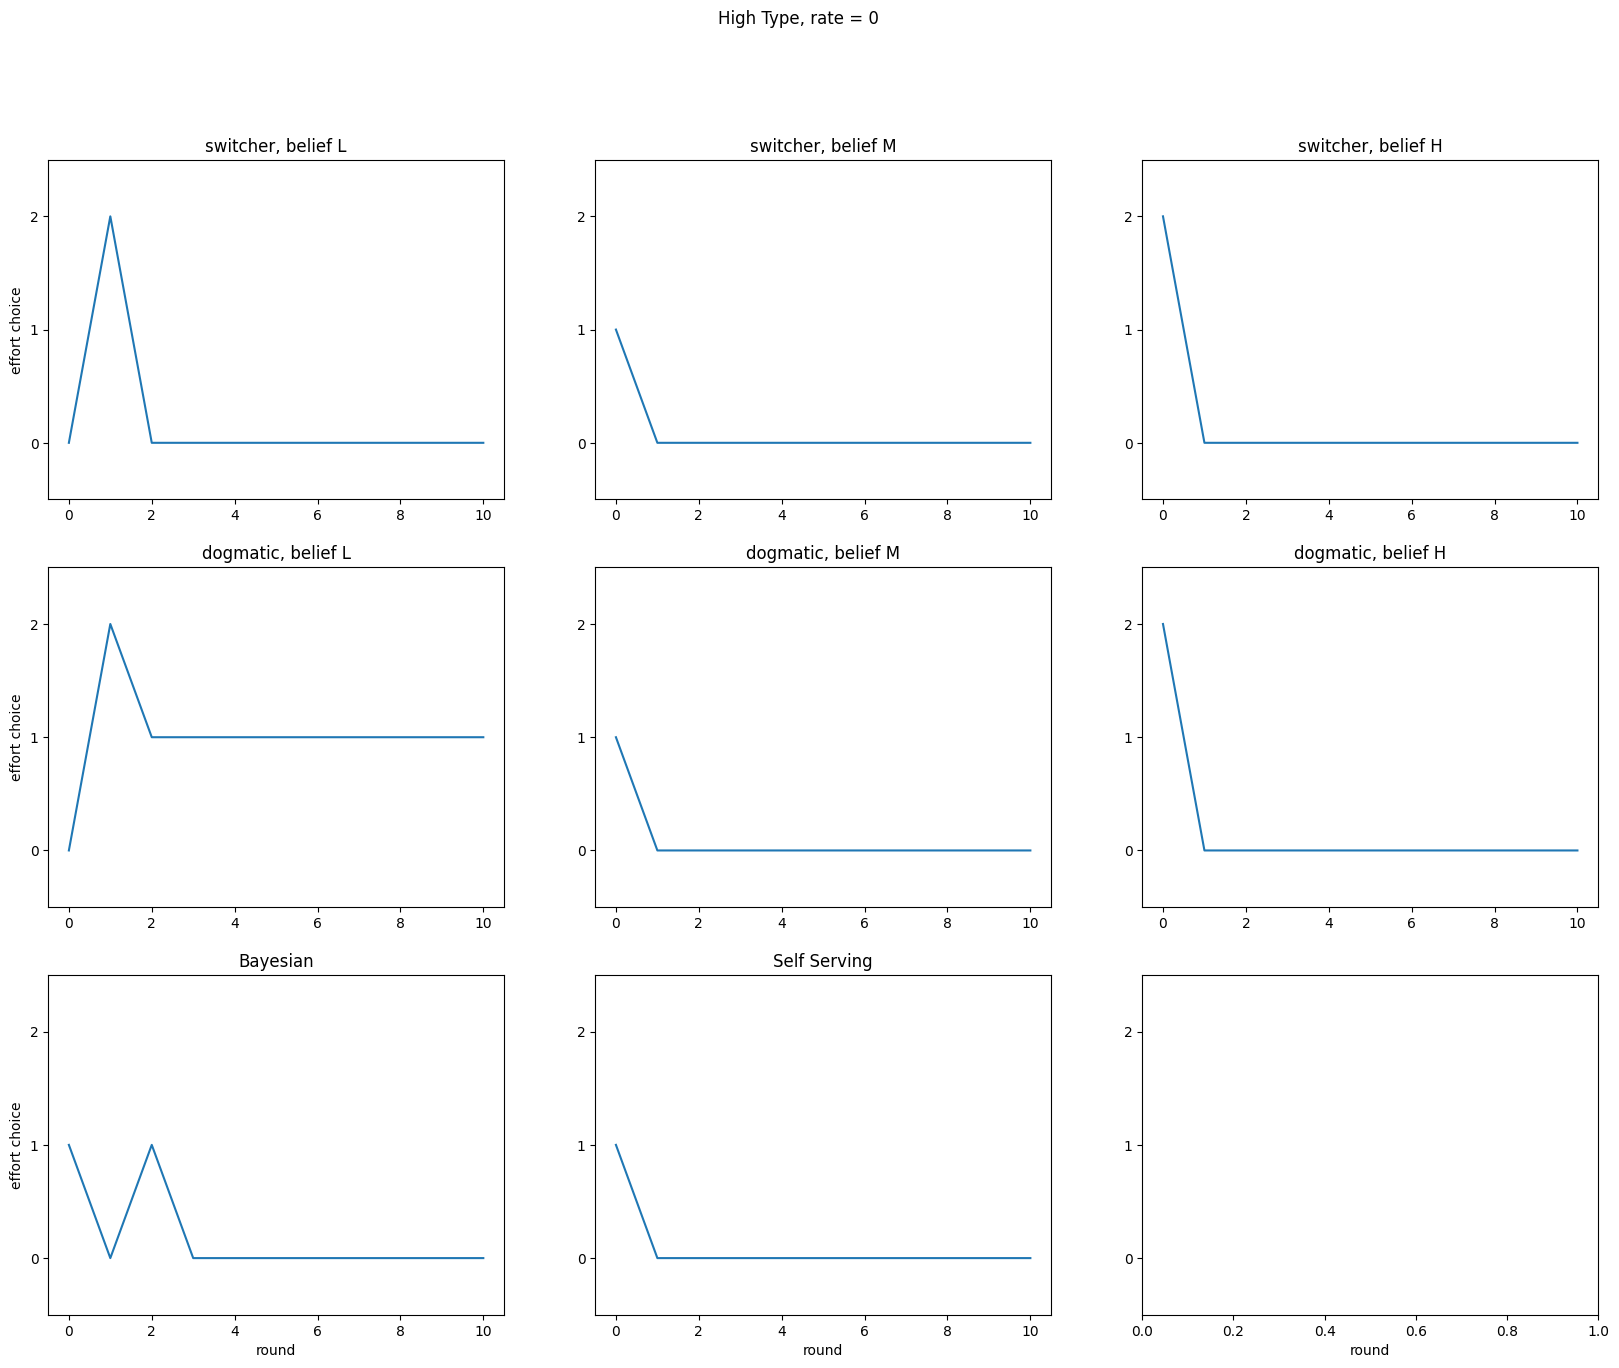

In [29]:
plot(choices_20, 2, 0)


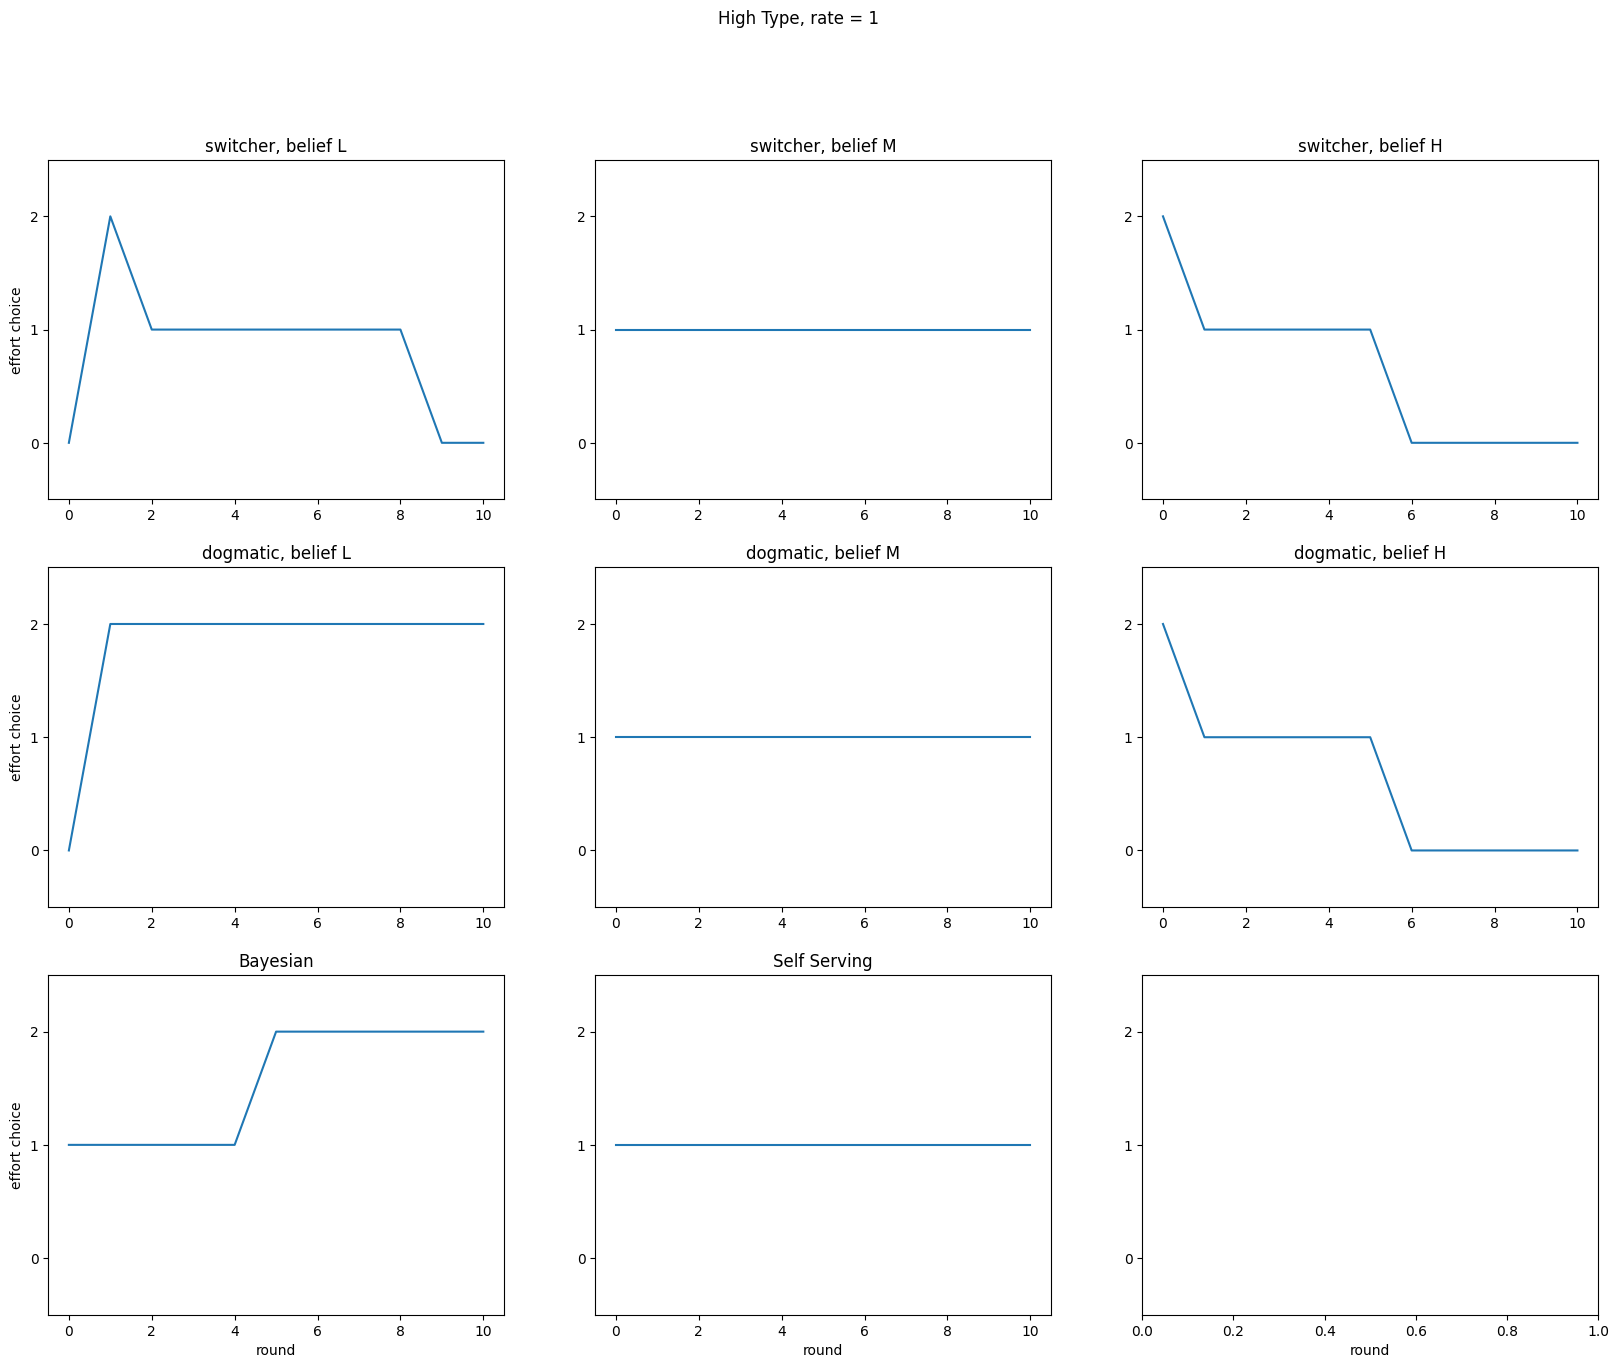

In [30]:
plot(choices_21, 2, 1)


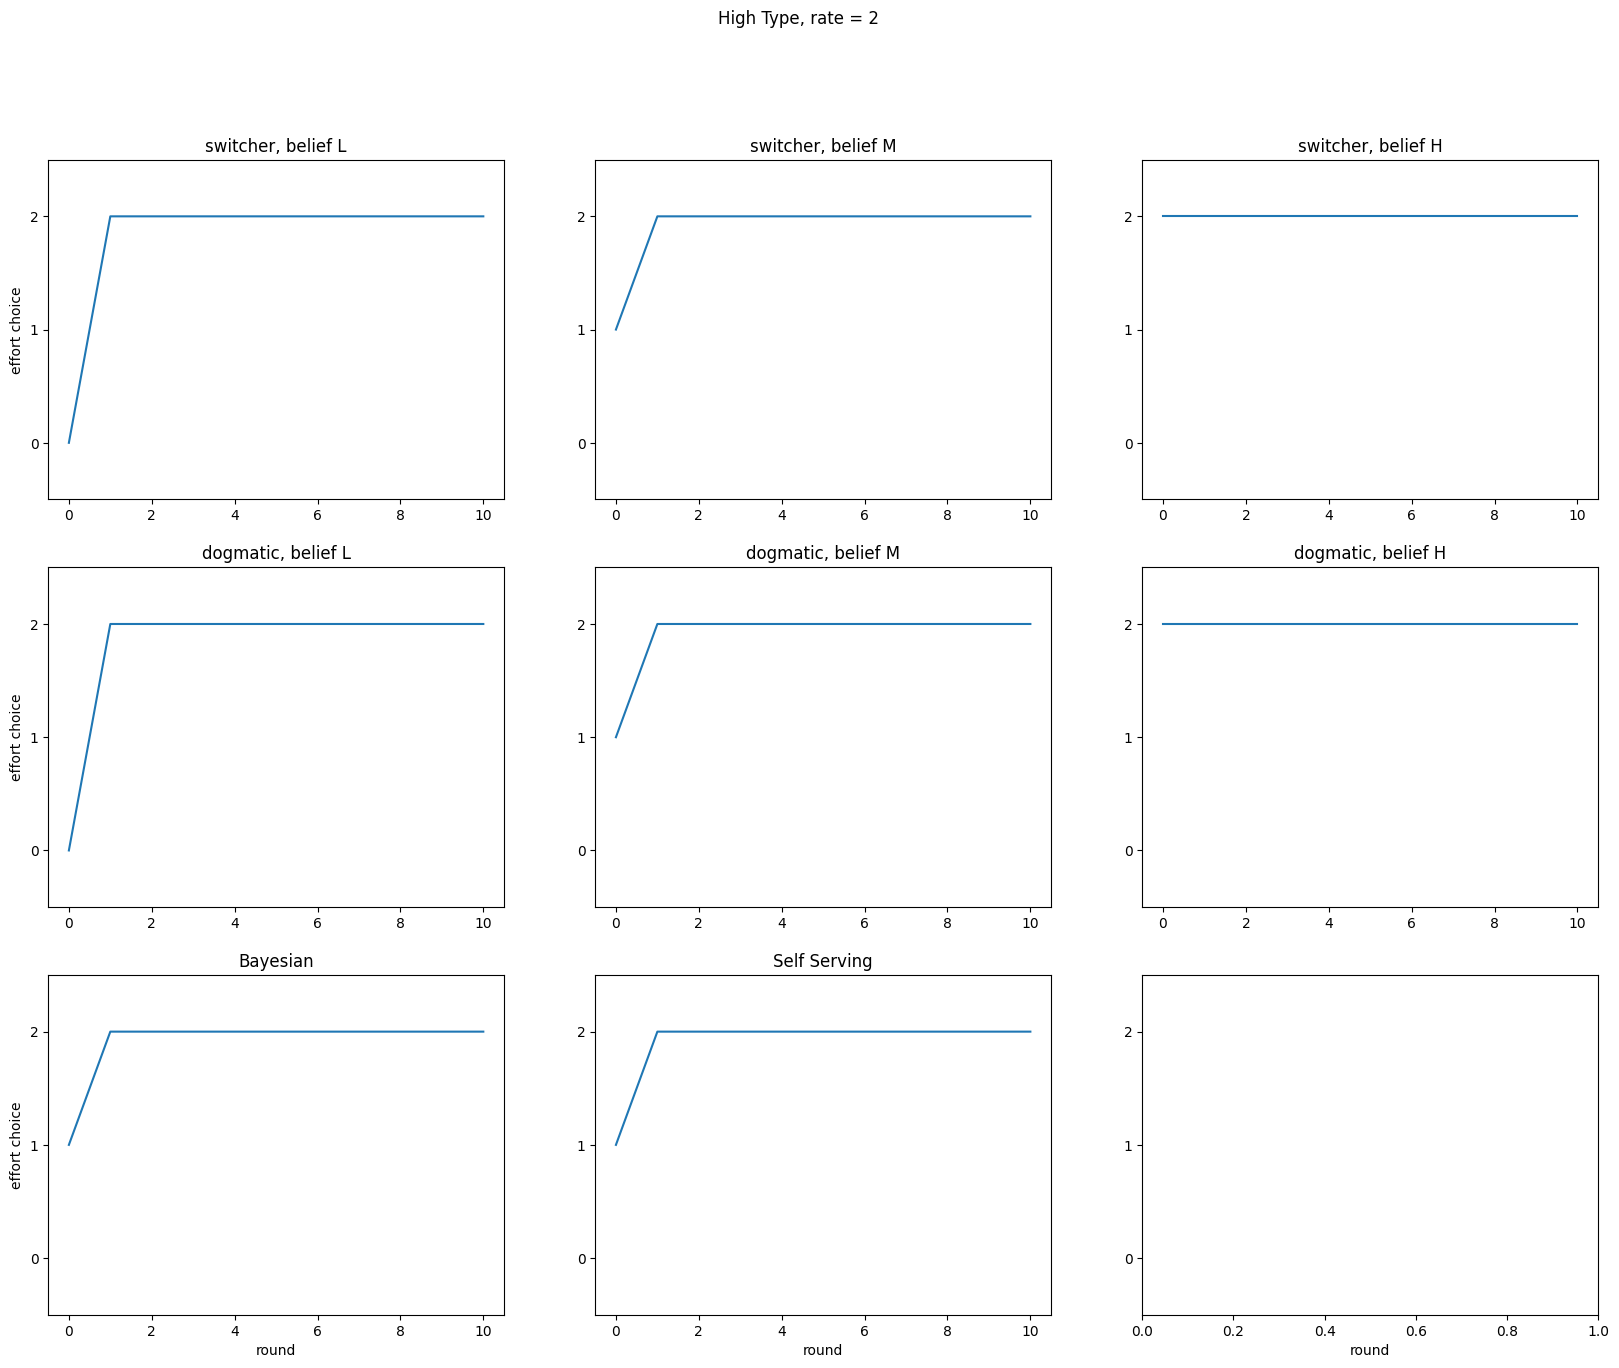

In [31]:
plot(choices_22, 2, 2)

In [32]:
# create a grid of parameters for the self-attribution bias (no base rate neglect yet)
values_high = np.linspace(1, 2, num=5)
values_low = np.linspace(.1, 1, num=5)
C = []
for val1 in values_high:
    for val2 in values_low:
        for val3 in values_low:
            for val4 in values_high:
                C.append([val1, val2, val3, val4])


In [ ]:
## simulate the self-attribution bias for all the  parameters
def simulate_ss_grid(theta, omega, p0_theta, p0_omega, M, c, d, T, N, trials, seeds, a, outcomes):
    #############
    # set empty vectors where all the data will be saved period by period for each of the models
    ############
    # beliefs
    
    p_theta_ss =[p0_theta]
    p_omega_ss = [p0_omega]
    
    # choices
    
    e_ss = [choice_bay(p0_theta, p0_omega, M)]
    
    signals = outcomes[theta]
    
    for t in range(T):
        # get the signals
        signal_ss = signals[e_ss[t], omega]
        
        # update beliefs
        ss_theta, ss_omega, ss_lr = bayes_biases(c, d, p_theta_ss[t], p_omega_ss[t], signal_ss, M, e_ss[t])
        p_theta_ss.append(ss_theta)
        p_omega_ss.append(ss_omega)
        
        # Choices
        e_ss_t = choice_bay(ss_theta, ss_omega, M)
        e_ss.append(e_ss_t)
        
    return e_ss, ss_theta, signals

In [ ]:
theta = 1
omega = 2
M = msc

periods = np.linspace(0, T, T+1)

ss_choices_params = []
ss_theta_params = []
ss_signals_params = []
ss_c = []



###### Determine the outcomes beforehand
# set a seed for each type
rng_H = np.random.default_rng(seed=seeds[0])
rng_M = np.random.default_rng(seed=seeds[1])
rng_L = np.random.default_rng(seed=seeds[2])

#############
# generate all the draws for T periods for each type and for each effort choice
############

##### for the high types
# outcomes after choosing L
outcome_H_L = rng_H.binomial(1, M[2][0, omega], size=(T, be_trials))
# outcomes after choosing M
outcome_H_M = rng_H.binomial(1, M[2][1, omega], size=(T, be_trials))
# outcomes after choosing H
outcome_H_H = rng_H.binomial(1, M[2][2, omega], size=(T, be_trials))

##### for the medium types
# after low effort
outcome_M_L = rng_M.binomial(1, M[1][0, omega], size=(T, be_trials))
# after medium effort
outcome_M_M = rng_M.binomial(1, M[1][1, omega], size=(T, be_trials))
# after high effort
outcome_M_H = rng_M.binomial(1, M[1][2, omega], size=(T, be_trials))

#### for the low types
outcomes_L_L = rng_L.binomial(1, M[0][0, omega], size=(T, be_trials))
outcomes_L_M = rng_L.binomial(1, M[0][1, omega], size=(T, be_trials))
outcomes_L_H = rng_L.binomial(1, M[0][2, omega], size=(T, be_trials))

# stack the outcome vectors foe each type into a matrix. first element is the effort choice, secod is t
outcomes_H = np.stack((outcome_H_L, outcome_H_M, outcome_H_H))
outcomes_M = np.stack((outcome_M_L, outcome_M_M, outcome_M_H))
outcomes_L = np.stack((outcomes_L_L, outcomes_L_M, outcomes_L_H))

# stack all the matrices into a single outcomes matrix of matrices
outcomes = np.stack((outcomes_L, outcomes_M, outcomes_H))


for c in C:
    e , th, signals = simulate_ss_grid(theta, omega, [1/3,1/3, 1/3], [1/3,1/3, 1/3], msc, c, 1, T, 1, be_trials, [385,385,385], a, outcomes)
    ss_choices_params.append(e)
    ss_theta_params.append(th)
    ss_signals_params.append(signals)
    ss_c.append(c)
    
choices_df = pd.DataFrame(ss_choices_params, columns =[str(p) for p in periods])
parameters = pd.DataFrame(ss_c, columns = ['theta_good', 'theta_bad', 'omega_good', 'omega_bad'])

choices_params = pd.concat([parameters, choices_df], axis=1)

In [ ]:
eb , thb, signalsb = simulate_ss_grid(theta, omega, [1/3,1/3, 1/3], [1/3,1/3, 1/3], msc, [1, 1, 1, 1], 1, T, 1, be_trials, [3,3,3], a, outcomes)

In [ ]:
long = choices_params.melt(id_vars=['theta_good', 'theta_bad', 'omega_good', 'omega_bad'] )
long.rename(columns={"variable":"round_number", "value":"choice"}, inplace=T)
long['round_number'] = long['round_number'].astype(float)

In [ ]:
self_serving = long.loc[(long['theta_good']>long['theta_bad']) & (long['omega_good']<long['omega_bad']), :]
self_serving['ratio_theta'] = self_serving['theta_good']/self_serving['theta_bad']
self_serving['ratio_omega'] = self_serving['omega_good']/self_serving['omega_bad']

no_attribution = long.loc[(long['theta_good']==long['theta_bad']) & (long['omega_good']==long['omega_bad']), :]
no_attribution['ratio_theta'] = no_attribution['theta_good']/no_attribution['theta_bad']
no_attribution['ratio_omega'] = no_attribution['omega_good']/no_attribution['omega_bad']

<ipython-input-28-0d670c07931e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self_serving['ratio_theta'] = self_serving['theta_good']/self_serving['theta_bad']
<ipython-input-28-0d670c07931e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self_serving['ratio_omega'] = self_serving['omega_good']/self_serving['omega_bad']
<ipython-input-28-0d670c07931e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



In [ ]:
omega_biases = np.sort(self_serving['ratio_omega'].unique())

In [ ]:
self_serving[self_serving['ratio_omega']==.05]

,theta_good,theta_bad,omega_good,omega_bad,round_number,choice,ratio_theta,ratio_omega
4,1.00,0.100,0.1,2.0,0.0,1,10.000000,0.05
29,1.00,0.325,0.1,2.0,0.0,1,3.076923,0.05
54,1.00,0.550,0.1,2.0,0.0,1,1.818182,0.05
79,1.00,0.775,0.1,2.0,0.0,1,1.290323,0.05
129,1.25,0.100,0.1,2.0,0.0,1,12.500000,0.05
...,...,...,...,...,...,...,...,...
6754,2.00,0.100,0.1,2.0,10.0,2,20.000000,0.05
6779,2.00,0.325,0.1,2.0,10.0,2,6.153846,0.05
6804,2.00,0.550,0.1,2.0,10.0,2,3.636364,0.05
6829,2.00,0.775,0.1,2.0,10.0,2,2.580645,0.05


In [ ]:
omega_biases[0]

0.05

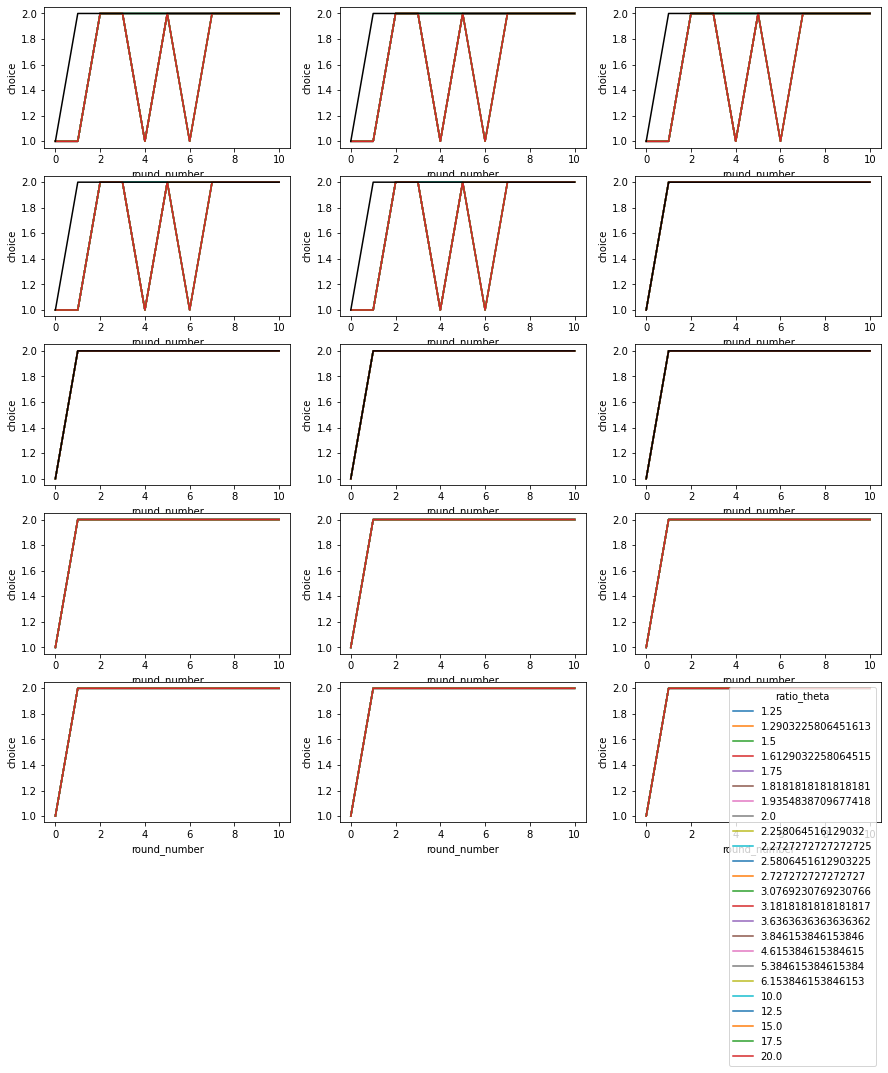

In [ ]:
fig, axs = plt.subplots(5, 3, figsize=(15, 15))

sns.lineplot(ax=axs[0, 0],
             data=self_serving[(self_serving['ratio_omega']==omega_biases[0])], 
             x="round_number", 
             y='choice', 
             hue='ratio_theta', 
             palette = 'tab10')


sns.lineplot(ax=axs[0, 1],
             data=self_serving[(self_serving['ratio_omega']==omega_biases[1])], 
             x="round_number", 
             y='choice', 
             hue='ratio_theta', 
             palette = 'tab10')


sns.lineplot(ax=axs[0, 2],
             data=self_serving[(self_serving['ratio_omega']==omega_biases[2])], 
             x="round_number", 
             y='choice', 
             hue='ratio_theta', 
             palette = 'tab10')


sns.lineplot(ax=axs[1, 0],
             data=self_serving[(self_serving['ratio_omega']==omega_biases[3])], 
             x="round_number", 
             y='choice', 
             hue='ratio_theta', 
             palette = 'tab10')


sns.lineplot(ax=axs[1, 1],
             data=self_serving[(self_serving['ratio_omega']==omega_biases[4])], 
             x="round_number", 
             y='choice', 
             hue='ratio_theta', 
             palette = 'tab10')


sns.lineplot(ax=axs[1, 2],
             data=self_serving[(self_serving['ratio_omega']==omega_biases[5])], 
             x="round_number", 
             y='choice', 
             hue='ratio_theta', 
             palette = 'tab10')


sns.lineplot(ax=axs[2, 0],
             data=self_serving[(self_serving['ratio_omega']==omega_biases[6])], 
             x="round_number", 
             y='choice', 
             hue='ratio_theta', 
             palette = 'tab10')


sns.lineplot(ax=axs[2, 1],
             data=self_serving[(self_serving['ratio_omega']==omega_biases[7])], 
             x="round_number", 
             y='choice', 
             hue='ratio_theta', 
             palette = 'tab10')


sns.lineplot(ax=axs[2, 2],
             data=self_serving[(self_serving['ratio_omega']==omega_biases[8])], 
             x="round_number", 
             y='choice', 
             hue='ratio_theta', 
             palette = 'tab10')

sns.lineplot(ax=axs[3, 0],
             data=self_serving[(self_serving['ratio_omega']==omega_biases[9])], 
             x="round_number", 
             y='choice', 
             hue='ratio_theta', 
             palette = 'tab10')


sns.lineplot(ax=axs[3, 1],
             data=self_serving[(self_serving['ratio_omega']==omega_biases[10])], 
             x="round_number", 
             y='choice', 
             hue='ratio_theta', 
             palette = 'tab10')


sns.lineplot(ax=axs[3, 2],
             data=self_serving[(self_serving['ratio_omega']==omega_biases[11])], 
             x="round_number", 
             y='choice', 
             hue='ratio_theta', 
             palette = 'tab10')

sns.lineplot(ax=axs[4, 0],
             data=self_serving[(self_serving['ratio_omega']==omega_biases[21])], 
             x="round_number", 
             y='choice', 
             hue='ratio_theta', 
             palette = 'tab10')


sns.lineplot(ax=axs[4, 1],
             data=self_serving[(self_serving['ratio_omega']==omega_biases[22])], 
             x="round_number", 
             y='choice', 
             hue='ratio_theta', 
             palette = 'tab10')


sns.lineplot(ax=axs[4, 2],
             data=self_serving[(self_serving['ratio_omega']==omega_biases[23])], 
             x="round_number", 
             y='choice', 
             hue='ratio_theta', 
             palette = 'tab10')



axs[0, 0].plot(eb, color='black')
axs[0, 1].plot(eb, color='black')
axs[0, 2].plot(eb, color='black')
axs[1, 0].plot(eb, color='black')
axs[1, 1].plot(eb, color='black')
axs[1, 2].plot(eb, color='black')
axs[2, 0].plot(eb, color='black')
axs[2, 1].plot(eb, color='black')
axs[2, 2].plot(eb, color='black')

axs[0,0].legend([],[], frameon=False)
axs[0,1].legend([],[], frameon=False)
axs[0,2].legend([],[], frameon=False)
axs[1,0].legend([],[], frameon=False)
axs[1,1].legend([],[], frameon=False)
axs[1,2].legend([],[], frameon=False)
axs[2,0].legend([],[], frameon=False)
axs[2,1].legend([],[], frameon=False)
axs[2,2].legend([],[], frameon=False)
axs[3,0].legend([],[], frameon=False)
axs[3,1].legend([],[], frameon=False)
axs[3,2].legend([],[], frameon=False)
axs[4,0].legend([],[], frameon=False)
axs[4,1].legend([],[], frameon=False)




In [44]:
# turn the choices_tw tables into a single data set by adding a column for the parameter values
df_00 = pd.DataFrame(np.array(choices_00).transpose(), 
             columns = ['e_lr_L', 'e_lr_M', 'e_lr_H', 'e_dog_L', 'e_dog_M', 'e_dog_H', 
            'e_bay', 'e_ss', 'theta_lr_L', 'theta_lr_M', 'theta_lr_H'])

df_00['theta'] = 0
df_00['omega'] = 0

# add a column called round_number that ranges from 0 to T 
df_00['round_number'] = np.linspace(0, T, T+1)

df_01 = pd.DataFrame(np.array(choices_01).transpose(),  
             columns = ['e_lr_L', 'e_lr_M', 'e_lr_H', 'e_dog_L', 'e_dog_M', 'e_dog_H', 
            'e_bay', 'e_ss', 'theta_lr_L', 'theta_lr_M', 'theta_lr_H'])
df_01['theta'] = 0
df_01['omega'] = 1

# add a column called round_number that ranges from 0 to T 
df_01['round_number'] = np.linspace(0, T, T+1)

df_02 = pd.DataFrame(np.array(choices_02).transpose(),
                columns = ['e_lr_L', 'e_lr_M', 'e_lr_H', 'e_dog_L', 'e_dog_M', 'e_dog_H', 
                'e_bay', 'e_ss', 'theta_lr_L', 'theta_lr_M', 'theta_lr_H'])
df_02['theta'] = 0
df_02['omega'] = 2

# add a column called round_number that ranges from 0 to T 
df_02['round_number'] = np.linspace(0, T, T+1)

df_10 = pd.DataFrame(np.array(choices_10).transpose(),
                columns = ['e_lr_L', 'e_lr_M', 'e_lr_H', 'e_dog_L', 'e_dog_M', 'e_dog_H', 
                'e_bay', 'e_ss', 'theta_lr_L', 'theta_lr_M', 'theta_lr_H'])
df_10['theta'] = 1
df_10['omega'] = 0

# add a column called round_number that ranges from 0 to T 
df_10['round_number'] = np.linspace(0, T, T+1)

df_11 = pd.DataFrame(np.array(choices_11).transpose(),
                columns = ['e_lr_L', 'e_lr_M', 'e_lr_H', 'e_dog_L', 'e_dog_M', 'e_dog_H', 
                'e_bay', 'e_ss', 'theta_lr_L', 'theta_lr_M', 'theta_lr_H'])
df_11['theta'] = 1
df_11['omega'] = 1

# add a column called round_number that ranges from 0 to T 
df_11['round_number'] = np.linspace(0, T, T+1)

df_12 = pd.DataFrame(np.array(choices_12).transpose(),
                columns = ['e_lr_L', 'e_lr_M', 'e_lr_H', 'e_dog_L', 'e_dog_M', 'e_dog_H', 
                'e_bay', 'e_ss', 'theta_lr_L', 'theta_lr_M', 'theta_lr_H'])
df_12['theta'] = 1  
df_12['omega'] = 2

# add a column called round_number that ranges from 0 to T 
df_12['round_number'] = np.linspace(0, T, T+1)

df_20 = pd.DataFrame(np.array(choices_20).transpose(),
                columns = ['e_lr_L', 'e_lr_M', 'e_lr_H', 'e_dog_L', 'e_dog_M', 'e_dog_H', 
                'e_bay', 'e_ss', 'theta_lr_L', 'theta_lr_M', 'theta_lr_H'])
df_20['theta'] = 2
df_20['omega'] = 0

# add a column called round_number that ranges from 0 to T 
df_20['round_number'] = np.linspace(0, T, T+1)

df_21 = pd.DataFrame(np.array(choices_21).transpose(),
                columns = ['e_lr_L', 'e_lr_M', 'e_lr_H', 'e_dog_L', 'e_dog_M', 'e_dog_H', 
                'e_bay', 'e_ss', 'theta_lr_L', 'theta_lr_M', 'theta_lr_H'])
df_21['theta'] = 2
df_21['omega'] = 1

# add a column called round_number that ranges from 0 to T 
df_21['round_number'] = np.linspace(0, T, T+1)

df_22 = pd.DataFrame(np.array(choices_22).transpose(),
                columns = ['e_lr_L', 'e_lr_M', 'e_lr_H', 'e_dog_L', 'e_dog_M', 'e_dog_H', 
                'e_bay', 'e_ss', 'theta_lr_L', 'theta_lr_M', 'theta_lr_H'])
df_22['theta'] = 2
df_22['omega'] = 2

# add a column called round_number that ranges from 0 to T 
df_22['round_number'] = np.linspace(0, T, T+1)

choices_all = pd.concat([df_00, df_01, df_02, df_10, df_11, df_12, df_20, df_21, df_22], axis=0)

'/Users/jimenagalindo/Documents/Overconfidence/Simulations'

In [57]:
from pathlib import Path  
filepath = Path('demo/data/simulation.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
choices_all.to_csv(filepath)


In [39]:
df_00

,e_lr_L,e_lr_M,e_lr_H,e_dog_L,e_dog_M,e_dog_H,e_bay,e_ss,theta_lr_L,theta_lr_M,theta_lr_H,theta,omega
0,0,1,2,0,1,2,1,1,0,1,2,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0
